In [1]:
pip install -U d2l

Requirement already up-to-date: d2l in /home/cozyboy/anaconda3/lib/python3.8/site-packages (0.16.1)


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install pytorch torchvision cpuonly -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /home/cozyboy/anaconda3

  added / updated specs:
    - cpuonly
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cpuonly-1.0                |                0           2 KB  pytorch
    libuv-1.40.0               |       h7b6447c_0         736 KB
    ninja-1.10.2               |   py38hff7bd54_0         1.4 MB
    pytorch-1.7.1              |      py3.8_cpu_0        59.5 MB  pytorch
    torchvision-0.8.2          |         py38_cpu        17.2 MB  pytorch
    ------------------------------------------------------------
                                           Total:        78.9 MB

The following NEW packages will be INSTALLED:

  cpuonly            pytorch/noarch::cpuonly-1.0-0
  libuv              pkgs/main/linux-64::libuv-1.40.0-h7b6447c_0
  ninja              pkgs/main/linux-64::

In [12]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np
import time
import random

In [5]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [6]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [7]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.09916 sec'

In [8]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00083 sec'

In [9]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

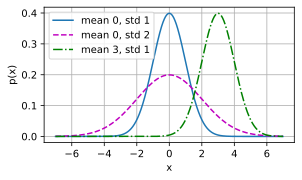

In [11]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [13]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 1.3305, -0.7457]) 
label: tensor([9.4053])


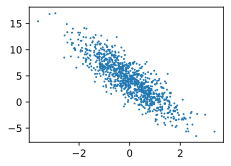

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1)

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5714, -0.9030],
        [ 1.2631,  0.8820],
        [ 1.2006, -0.5653],
        [-0.0170, -1.2045],
        [ 0.2371,  0.4341],
        [-0.3071, -1.1635],
        [-0.1874,  0.6044],
        [ 1.1304,  0.3343],
        [ 2.2896, -0.8870],
        [-0.6715, -1.6117]]) 
 tensor([[ 6.1185],
        [ 3.7312],
        [ 8.5300],
        [ 8.2626],
        [ 3.2062],
        [ 7.5518],
        [ 1.7458],
        [ 5.3248],
        [11.8054],
        [ 8.3352]])


In [18]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [21]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [24]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [22]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [25]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040816
epoch 2, loss 0.000157
epoch 3, loss 0.000048


## Using high-level APIs of PyTorch

In [2]:
from d2l import torch as d2l
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [3]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [5]:
next(iter(data_iter))

[tensor([[ 1.6471,  0.1441],
         [-0.0287,  0.1613],
         [-0.4333,  0.5925],
         [ 0.0484, -0.7131],
         [ 1.4083,  0.5229],
         [ 0.6067, -1.1002],
         [-1.2040, -0.5135],
         [ 0.7200,  0.3230],
         [-1.9455,  0.1733],
         [-0.4594, -1.1030]]),
 tensor([[ 6.9976],
         [ 3.5897],
         [ 1.3193],
         [ 6.7237],
         [ 5.2394],
         [ 9.1666],
         [ 3.5506],
         [ 4.5420],
         [-0.2736],
         [ 7.0471]])]

In [6]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [7]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [9]:
loss = nn.MSELoss()

In [10]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [11]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000333
epoch 2, loss 0.000106
epoch 3, loss 0.000106


In [12]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-7.5579e-05,  9.2411e-04])
error in estimating b: tensor([0.0004])
